In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import torch
import matplotlib.pyplot as plt

# Callbacks as gui events

In [3]:
import ipywidgets as widgets

In [4]:
def f(o): print('hi')

In [5]:
w = widgets.Button(description='Click me')

In [6]:
w

Button(description='Click me', style=ButtonStyle())

In [7]:
w.on_click(f)

# creating your own callback

In [8]:
from time import sleep

In [9]:
def slow_calculation():
    res = 0
    for i in range(5):
        res += 1*i
        sleep(1)
    return res

In [10]:
slow_calculation()

10

In [11]:
def slow_calculation(cb=None):
    res = 0
    for i in range(5):
        res += 1*i
        sleep(1)
        if cb: cb(i)
    return res

In [12]:
def show_progress(epoch):
    print(f'Awesome! Weve finished epoch: {epoch}!')

In [13]:
slow_calculation(show_progress)

Awesome! Weve finished epoch: 0!
Awesome! Weve finished epoch: 1!
Awesome! Weve finished epoch: 2!
Awesome! Weve finished epoch: 3!
Awesome! Weve finished epoch: 4!


10

# Lambdas and partials

In [14]:
slow_calculation(lambda o: print(f'Awesome! WEve finished epoch {o}!'))

Awesome! WEve finished epoch 0!
Awesome! WEve finished epoch 1!
Awesome! WEve finished epoch 2!
Awesome! WEve finished epoch 3!
Awesome! WEve finished epoch 4!


10

In [15]:
def show_progress(exclamation, epoch):
    print(f'{exclamation}! Weve finished epoch {epoch}!')

In [16]:
slow_calculation(lambda o: show_progress('Ok I guess', o))

Ok I guess! Weve finished epoch 0!
Ok I guess! Weve finished epoch 1!
Ok I guess! Weve finished epoch 2!
Ok I guess! Weve finished epoch 3!
Ok I guess! Weve finished epoch 4!


10

In [17]:
def make_show_progress(exclamation):
    _inner = lambda epoch: print(f'{exclamation}! Weve finished epoch {epoch}!')
    return _inner

In [18]:
slow_calculation(make_show_progress('blah'))

blah! Weve finished epoch 0!
blah! Weve finished epoch 1!
blah! Weve finished epoch 2!
blah! Weve finished epoch 3!
blah! Weve finished epoch 4!


10

In [19]:
def make_show_progress(exclamation):
    def _inner(epoch): print(f'{exclamation}! Weve finished epoch {epoch}!')
    return _inner

In [20]:
slow_calculation(make_show_progress('Amazing'))

Amazing! Weve finished epoch 0!
Amazing! Weve finished epoch 1!
Amazing! Weve finished epoch 2!
Amazing! Weve finished epoch 3!
Amazing! Weve finished epoch 4!


10

In [21]:
from functools import partial

In [22]:
slow_calculation(partial(show_progress, "Ok I guess"))

Ok I guess! Weve finished epoch 0!
Ok I guess! Weve finished epoch 1!
Ok I guess! Weve finished epoch 2!
Ok I guess! Weve finished epoch 3!
Ok I guess! Weve finished epoch 4!


10

# Callbacks as callable classes

In [23]:
class ProgressShowingCallback():
    def __init__(self, exclamation='Awesome'): self.exclamation = exclamation
    def __call__(self, epoch): print(f'{self.exclamation}! Weve finished epoch{epoch}!')

In [24]:
cb = ProgressShowingCallback('Just super')

In [25]:
cb('Hi')

Just super! Weve finished epochHi!


In [26]:
slow_calculation(cb)

Just super! Weve finished epoch0!
Just super! Weve finished epoch1!
Just super! Weve finished epoch2!
Just super! Weve finished epoch3!
Just super! Weve finished epoch4!


10

# Multiple Callback functions

In [27]:
def f(*args, **kwargs):
    print(f'args: {args}; kwargs: {kwargs}')

In [28]:
f(3, 'a', thing1='hello')

args: (3, 'a'); kwargs: {'thing1': 'hello'}


In [29]:
def slow_calculation(cb=None):
    res=0
    for i in range(5):
        if cb: cb.before_calc(i)
        res += i*i
        sleep(1)
        if cb: cb.after_calc(i, val=res)
    return res

In [30]:
class PrintStepCallback():
    def __init__(self): pass
    def before_calc(self, *args, **kwargs): print(f'About to start')
    def after_calc(self,  *args, **kwargs): print(f'Done step')

In [31]:
slow_calculation(PrintStepCallback())

About to start
Done step
About to start
Done step
About to start
Done step
About to start
Done step
About to start
Done step


30

# Modifying behavior

In [32]:
def slow_calculation(cb=None):
    res = 0
    for i in range(5):
        if cb and hasattr(cb, 'before_calc'): cb.before_calc(i)
        res += i*i
        sleep(1)
        if cb and hasattr(cb, 'after_calc'):
            if cb.after_calc(i, res):
                print('stopping early')
                break
    return res
        

In [33]:
class PrintAfterCallback():
    def after_calc(self, epoch, val):
        print(f'After {epoch}: {val}')
        if val>10: return True

In [34]:
slow_calculation(PrintAfterCallback())

After 0: 0
After 1: 1
After 2: 5
After 3: 14
stopping early


14

In [35]:
class SlowCalculator():
    def __init__(self, cb=None): self.cb, self.res=cb,0
        
    def __call__(self, cb_name, *args):
        if not self.cb: return
        cb = getattr(self.cb, cb_name, None)
        if cb: return cb(self, *args)
        
    def calc(self):
        for i in range(5):
            self('before_calc', i)
            self.res += i*i
            sleep(1)
            if self('after_calc', i):
                print('stopping early')
                break

In [36]:
class ModifyingCallback():
    def after_calc(self, calc, epoch):
        print(f'After {epoch}: {calc.res}')
        if calc.res > 10: return True
        if calc.res < 3: calc.res = calc.res*2

In [37]:
calculator = SlowCalculator(ModifyingCallback())

In [38]:
calculator.calc()
calculator.res

After 0: 0
After 1: 1
After 2: 6
After 3: 15
stopping early


15

# __dunder__ thingies

In [39]:
class SloppyAdder():
    def __init__(self, o): self.o=o
    def __add__(self, b): return SloppyAdder(self.o + b.o + 0.01)
    def __repr__(self): return str(self.o)

In [40]:
a = SloppyAdder(1)
b = SloppyAdder(2)
a+b

3.01

# Variance and stuff

In [41]:
t = torch.tensor([1.,2,4,18])

In [42]:
m = t.mean(); m

tensor(6.2500)

In [43]:
(t-m).mean()

tensor(0.)

In [44]:
(t-m).pow(2).mean()

tensor(47.1875)

In [45]:
(t-m).abs().mean()

tensor(5.8750)

In [46]:
(t-m).pow(2).mean().sqrt()

tensor(6.8693)

In [47]:
(t-m).pow(2).mean(), (t*t).mean() - (m*m)

(tensor(47.1875), tensor(47.1875))

# Covariance and correlation

In [48]:
t

tensor([ 1.,  2.,  4., 18.])

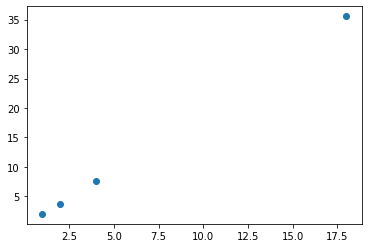

In [49]:
u = t*2
u *= torch.randn_like(t)/10+0.95

plt.scatter(t,u)

In [50]:
prod = (t-t.mean())*(u-u.mean()); prod

tensor([ 53.5679,  36.1049,  10.4559, 274.3128])

In [51]:
prod.mean()

tensor(93.6104)

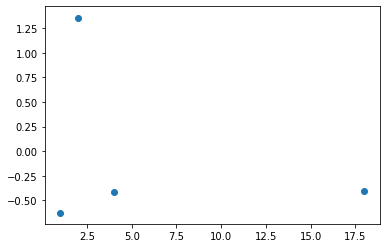

In [52]:
v = torch.randn_like(t)
plt.scatter(t, v)

In [53]:
((t-t.mean())*(v-v.mean())).mean()

tensor(-1.5932)

In [54]:
cov = (t*v).mean() - t.mean()*v.mean(); cov

tensor(-1.5932)

In [55]:
cov / (t.std() * v.std())

tensor(-0.2171)

# Softmax

In [56]:
def log_softmax(x): return x - x.exp().sum(-1, keepdim=True).log()

# Early Stopping

In [57]:
#export
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader

MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'

In [58]:
class Dataset():
    def __init__(self, x, y): self.x, self.y = x,y
    def __len__(self,): return len(self.x)
    def __getitem__(self, i): return self.x[i], self.y[i]

In [59]:
def get_data():
    path = datasets.download_data(MNIST_URL, ext='.gz')
    with gzip.open(path, 'rb') as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    return map(tensor, (x_train, y_train, x_valid, y_valid))

def normalize(x, m, s): return (x-m)/s

In [60]:
class DataBunch():
    def __init__(self, train_dl, valid_dl, c=None):
        self.train_dl, self.valid_dl, self.c = train_dl, valid_dl, c
        
    @property
    def train_ds(self): return self.train_dl.dataset
    
    @property
    def valid_ds(self): return self.valid_dl.dataset

In [61]:
def get_dls(train_ds, valid_ds, bs):
        return DataLoader(train_ds, batch_size=bs), DataLoader(valid_ds, batch_size=bs)

In [62]:
x_train, y_train, x_valid, y_valid = get_data()
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
nh, bs = 50, 512
c = y_train.max().item()+1
loss_func = F.cross_entropy

In [63]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [64]:
class Callback():
    _order=0
    def set_runner(self, run): self.run = run
    def __getattr__(self, k): return getattr(self.run, k)
    
    @property
    def name(self):
        name = re.sub(r'Callback$', '', self.__class__.__name__)
        return camel2snake(name or 'callback')
    
    def __call__(self, cb_name):
        f = getattr(self, cb_name, None)
        if f and f(): return True
        return False
    
class TrainEvalCallback(Callback):
    def begin_fit(self):
        self.run.n_epochs = 0
        self.run.n_iter = 0
        
    def after_batch(self):
        if not self.in_train: return
        self.run.n_epochs += 1./self.iters
        self.run.n_iter   += 1
        
    def begin_epoch(self):
        self.run.n_epochs=self.epoch
        self.model.train()
        self.run.in_train=True
        
    def begin_validate(self):
        self.model.eval()
        self.run.in_train=False
        
class CancelTrainException(Exception): pass
class CancelEpochException(Exception): pass
class CancelBatchException(Exception): pass

In [65]:
class Runner():
    def __init__(self, cbs=None, cb_funcs=None):
        cbs = listify(cbs)
        for cbf in listify(cb_funcs):
            cb = cbf()
            setattr(self, cb.name, cb)
            cbs.append(cb)
        self.stop, self.cbs = False, [TrainEvalCallback()]+cbs
        
    @property
    def opt(self):       return self.learn.opt
    @property
    def model(self):     return self.learn.model
    @property
    def loss_func(self): return self.learn.loss_func
    @property
    def data(self):      return self.learn.data
    
    def one_batch(self, xb, yb):
        try:
            self.xb, self.yb = xb, yb
            self('begin_batch')
            self.pred = self.model(self.xb)
            self('after_pred')
            self.loss = self.loss_func(self.pred, self.yb)
            self('after_loss')
            if not self.in_train: return
            self.loss.backward()
            self('after_backward')
            self.opt.step()
            self('after_step')
            self.opt.zero_grad()
        except CancelBatchException: self('after_cancel_batch')
        finally: self('after_batch')
        
    def all_batches(self, dl):
        self.iters = len(dl)
        try:
            for xb,yb in dl: self.one_batch(xb, yb)
        except CancelEpochException: self('after_cancel_epoch')
            
    def fit(self, epochs, learn):
        self.epochs, self.learn = epochs, learn
                    
        try:
            for cb in self.cbs: cb.set_runner(self)
            if self('begin_fit'): return
            for epoch in range(epochs):
                self.epoch = epoch
                if not self('begin_epoch'): self.all_batches(self.data.train_dl)
                    
                with torch.no_grad():
                    if not self('begin_validate'): self.all_batches(self.data.valid_dl)
                if self('after_epoch'): break
                
        except CancelTrainException: self('after_cancel_train')
        finally:
            self('after_fit')
            self.learn = None
            
    def __call__(self, cb_name):
        res = False
        for cb in sorted(self.cbs, key=lambda x:x._order): res = cb(cb_name) and res
        return res

In [66]:
def get_model(data, lr=0.5, nh=50):
    m = data.train_ds.x.shape[1]
    model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, data.c))
    return model, optim.SGD(model.parameters(), lr=lr)

class Learner():
    def __init__(self, model, opt, loss_func, data):
        self.model, self.opt, self.loss_func, self.data = model,opt,loss_func,data

In [67]:
def create_learner(model_func, loss_func, data):
    return Learner(*model_func(data), loss_func, data)

In [68]:
learn = create_learner(get_model, loss_func, data)

In [69]:
class TestCallback(Callback):
    _order=1
    def after_step(self):
        print(self.n_iter)
        if self.n_iter >= 10: raise CancelTrainException()

In [70]:
from typing import *

def listify(o):
    if o is None: return []
    if isinstance(o, list): return o
    if isinstance(o, Iterable): return list(o)
    return [o]

In [71]:
import re

_camel_re1 = re.compile('(.)([A-Z][a-z]+)')
_camel_re2 = re.compile('([a-z0-9])([A-Z])')
def camel2snake(name):
    s1 = re.sub(_camel_re1, r'\1_\2', name)
    return re.sub(_camel_re2, r'\1_\2', s1).lower()

In [72]:
run = Runner(cb_funcs=TestCallback)

In [73]:
run.fit(3, learn)

0
1
2
3
4
5
6
7
8
9
10


# LR Finder

In [74]:
class Recorder(Callback):
    def begin_fit(self): self.lrs, self.losses = [],[]
    
    def after_batch(self):
        if not self.in_train: return
        self.lrs.append(self.opt.param_groups[-1]['lr'])
        self.losses.append(self.loss.detach().cpu())
        
    def plot_lr(self): plt.plot(self.lrs)
    def plot_loss(self): plt.plot(self.losses)

In [75]:
class LR_Find(Callback):
    _order=1
    def __init__(self, max_iter=100, min_lr=1e-6, max_lr=10):
        self.max_iter, self.min_lr, self.max_lr = max_iter, min_lr, max_lr
        self.best_loss = 1e9
        
    def begin_batch(self):
        if not self.in_train: return
        pos = self.n_iter/self.max_iter
        lr = self.min_lr * (self.max_lr/self.min_lr) ** pos
        for pg in self.opt.param_groups: pg['lr'] = lr
            
    def after_step(self):
        if self.n_iter >= self.max_iter or self.loss > self.best_loss*10:
            raise CancelTrainException()
        if self.loss < self.best_loss: self.best_loss = self.loss

In [76]:
learn = create_learner(get_model, loss_func, data)

In [77]:
run = Runner(cb_funcs=[LR_Find, Recorder])

In [78]:
run.fit(2, learn)

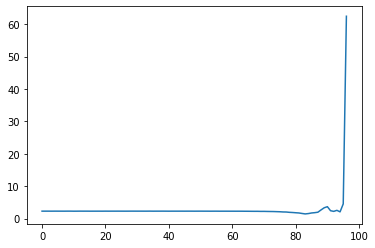

In [79]:
run.recorder.plot_loss()

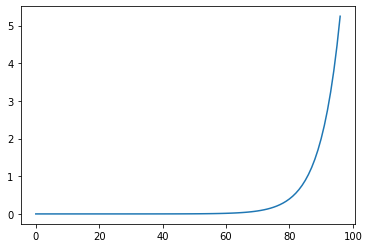

In [80]:
run.recorder.plot_lr()

# ConvNet

In [81]:
def normalize_to(train, valid):
    m,s = train.mean(), train.std()
    return normalize(train, m, s), normalize(valid, m, s)

In [82]:
x_train, x_valid = normalize_to(x_train, x_valid)
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)

In [83]:
x_train.mean(), x_train.std()

(tensor(-6.2598e-06), tensor(1.))

In [84]:
nh, bs = 50, 512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [85]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
        
    def forward(self, x): return self.func(x)
    
def flatten(x): return x.view(x.shape[0], -1)

In [86]:
def mnist_resize(x): return x.view(-1, 1, 28, 28)

In [87]:
def get_cnn_model(data):
    return nn.Sequential(
        Lambda(mnist_resize),
        nn.Conv2d( 1, 8, 5, padding=2, stride=2), nn.ReLU(),
        nn.Conv2d( 8,16, 3, padding=1, stride=2), nn.ReLU(),
        nn.Conv2d(16,32, 3, padding=1, stride=2), nn.ReLU(),
        nn.Conv2d(32,32, 3, padding=1, stride=2), nn.ReLU(),
        nn.AdaptiveAvgPool2d(1),
        Lambda(flatten),
        nn.Linear(32, data.c)
    )

In [88]:
model = get_cnn_model(data)

In [89]:
class AvgStats():
    def __init__(self, metrics, in_train):
        self.metrics, self.in_train = listify(metrics), in_train
        
    def reset(self):
        self.tot_loss, self.count = 0,0
        self.tot_mets = [0] * len(self.metrics)

    @property
    def all_stats(self): return [self.tot_loss.item()] + self.tot_mets
    @property
    def avg_stats(self): return [o/self.count for o in self.all_stats]

    def __repr__(self):
        if not self.count: return ""
        return f"{'train' if self.in_train else 'valid'}: {self.avg_stats}"

    def accumulate(self, run):
        bn = run.xb.shape[0]
        self.tot_loss += run.loss * bn
        self.count += bn
        for i,m in enumerate(self.metrics):
            self.tot_mets[i] += m(run.pred, run.yb) * bn

class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats, self.valid_stats = AvgStats(metrics, True), AvgStats(metrics,False)

    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()

    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad(): stats.accumulate(self.run)

    def after_epoch(self):
        print(self.train_stats)
        print(self.valid_stats)

In [90]:
def accuracy(out, yb): return (torch.argmax(out, dim=1)==yb).float().mean()

In [91]:
cbfs = [Recorder, partial(AvgStatsCallback, accuracy)]

In [92]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [93]:
%time run.fit(5, learn)

train: [2.01668171875, tensor(0.2966)]
valid: [0.9162884765625, tensor(0.7054)]
train: [0.545731484375, tensor(0.8290)]
valid: [0.2220960205078125, tensor(0.9348)]
train: [0.2184482421875, tensor(0.9334)]
valid: [0.15962476806640624, tensor(0.9511)]
train: [0.16513412109375, tensor(0.9495)]
valid: [0.1285360107421875, tensor(0.9609)]
train: [0.12228576171875, tensor(0.9628)]
valid: [0.1118086181640625, tensor(0.9662)]
CPU times: user 1min 32s, sys: 397 ms, total: 1min 33s
Wall time: 9.31 s


# Cuda

In [94]:
device = torch.device('cuda',0)

In [95]:
class CudaCallback(Callback):
    def __init__(self, device): self.device=device
    def begin_fit(self): self.model.to(device)
    def begin_batch(self): self.run.xb, self.run.yb = self.xb.to(device), self.yb.to(device)

In [96]:
torch.cuda.set_device(device)

In [97]:
class CudaCallback(Callback):
    def begin_fit(self): self.model.cuda()
    def begin_batch(self): self.run.xb, self.run.yb = self.xb.cuda(), self.yb.cuda()

In [98]:
cbfs.append(CudaCallback)

In [99]:
model = get_cnn_model(data)

In [100]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [101]:
%time run.fit(5, learn)

train: [2.01261078125, tensor(0.2966, device='cuda:0')]
valid: [0.648409033203125, tensor(0.7987, device='cuda:0')]
train: [0.4128865625, tensor(0.8725, device='cuda:0')]
valid: [0.228911669921875, tensor(0.9320, device='cuda:0')]
train: [0.18787501953125, tensor(0.9434, device='cuda:0')]
valid: [0.14789129638671875, tensor(0.9545, device='cuda:0')]
train: [0.13515736328125, tensor(0.9586, device='cuda:0')]
valid: [0.121071142578125, tensor(0.9633, device='cuda:0')]
train: [0.110134462890625, tensor(0.9666, device='cuda:0')]
valid: [0.1030711669921875, tensor(0.9678, device='cuda:0')]
CPU times: user 6.11 s, sys: 718 ms, total: 6.82 s
Wall time: 7.29 s


# Refactor model

In [102]:
def conv2d(ni, nf, ks=3, stride=2):
    return nn.Sequential(
    nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), nn.ReLU())

In [103]:
class BatchTransformXCallback(Callback):
    _order=2
    def __init__(self, tfm): self.tfm = tfm
    def begin_batch(self): self.run.xb = self.tfm(self.xb)
    
def view_tfm(*size):
    def _inner(x): return x.view(*((-1,)+size))
    return _inner

In [104]:
mnist_view = view_tfm(1,28,28)
cbfs.append(partial(BatchTransformXCallback, mnist_view))

In [105]:
nfs = [8,16,32,32]

In [106]:
def get_cnn_layers(data, nfs):
    nfs = [1] + nfs
    return [
        conv2d(nfs[i], nfs[i+1], 5 if i==0 else 3)
        for i in range(len(nfs)-1)
    ] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def get_cnn_model(data, nfs): return nn.Sequential(*get_cnn_layers(data, nfs))

In [107]:
def get_runner(model, data, lr=0.6, cbs=None, opt_func=None, loss_func = F.cross_entropy):
    if opt_func is None: opt_func = optim.SGD
    opt = opt_func(model.parameters(), lr=lr)
    learn = Learner(model, opt, loss_func, data)
    return learn, Runner(cb_funcs=listify(cbs))

In [108]:
model = get_cnn_model(data, nfs)
learn, run = get_runner(model, data, lr=0.4, cbs=cbfs)

In [109]:
run.fit(3, learn)

train: [1.71648078125, tensor(0.4154, device='cuda:0')]
valid: [0.590012548828125, tensor(0.8232, device='cuda:0')]
train: [0.37121171875, tensor(0.8854, device='cuda:0')]
valid: [0.2399897705078125, tensor(0.9257, device='cuda:0')]
train: [0.19294572265625, tensor(0.9403, device='cuda:0')]
valid: [0.17832445068359376, tensor(0.9439, device='cuda:0')]


# Hooks

In [110]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds = [[] for _ in layers]
        
    def __call__(self, x):
        for i, l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(x.data.mean())
            self.act_stds [i].append(x.data.std ())
        return x
    
    def __iter__(self): return iter(self.layers)

In [111]:
model = SequentialModel(*get_cnn_layers(data, nfs))
learn, run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [112]:
run.fit(2, learn)

train: [2.29279828125, tensor(0.1642, device='cuda:0')]
valid: [2.3013091796875, tensor(0.1064, device='cuda:0')]
train: [2.37947, tensor(0.1164, device='cuda:0')]
valid: [2.3017146484375, tensor(0.1064, device='cuda:0')]


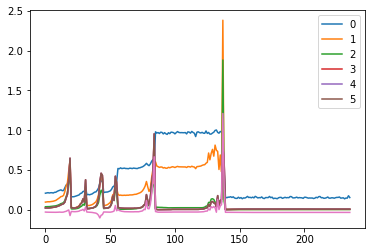

In [113]:
for l in model.act_means: plt.plot(l)
plt.legend(range(6))

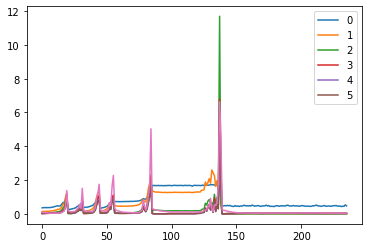

In [114]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(6))

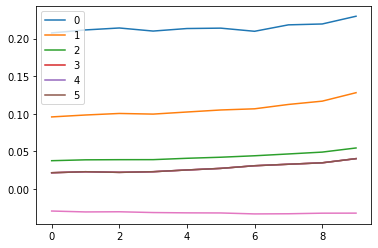

In [115]:
for l in model.act_means: plt.plot(l[:10])
plt.legend(range(6))

# Pytorch hooks

In [116]:
model = get_cnn_model(data, nfs)
learn, run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [117]:
act_means = [[] for _ in model]
act_stds  = [[] for _ in model]

In [118]:
def append_stats(i, mod, inp, outp):
    act_means[i].append(outp.data.mean())
    act_stds [i].append(outp.data.mean())

In [119]:
for i,m in enumerate(model): m.register_forward_hook(partial(append_stats, i))

In [120]:
run.fit(1, learn)

train: [2.1171759375, tensor(0.2480, device='cuda:0')]
valid: [1.24667314453125, tensor(0.5517, device='cuda:0')]


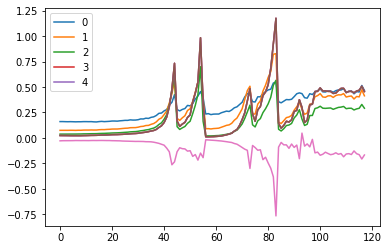

In [121]:
for o in act_means: plt.plot(o)
plt.legend(range(5))

# Hook class

In [122]:
def children(m): return list(m.children())

class Hook():
    def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()
        
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'): hook.stats =([],[])
    means, stds = hook.stats
    means.append(outp.data.mean())
    stds .append(outp.data.std())

In [123]:
model = get_cnn_model(data, nfs)
learn, run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [124]:
hooks = [Hook(l, append_stats) for l in children(model[:4])]

In [125]:
run.fit(1, learn)

train: [2.071264375, tensor(0.3066, device='cuda:0')]
valid: [0.746865771484375, tensor(0.7824, device='cuda:0')]


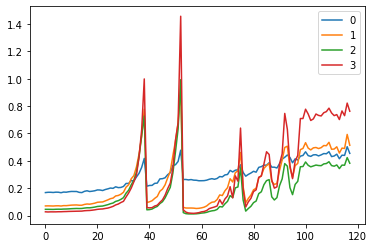

In [126]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(4))

# Hooks class

In [127]:
class ListContainer():
    def __init__(self, items): self.items = listify(items)
    def __getitem__(self, idx):
        if isinstance(idx, (int, slice)): return self.items[idx]
        if isinstance(idx[0], bool):
            assert len(idx)==len(self)
            return[0 for m,o in zip(idx, self.items) if m]
        return [self.items[i] for i in idx]
    def __len__(self): return len(self.items)
    def __iter__(self): return iter(self.items)
    def __setitem__(self, i, o): self.items[i] = o
    def __delitem__(self, i): del(self.items[i])
    def __repr__(self):
        res = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}'
        if len(self)>10: res = res[:-1]+ '...]'
        return res

In [128]:
ListContainer(range(10))

ListContainer (10 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [129]:
from torch.nn import init

class Hooks(ListContainer):
    def __init__(self, ms, f): super().__init__([Hook(m,f) for m in ms])
    def __enter__(self, *args): return self
    def __exit__ (self, *args): self.remove()
    def __del__(self): self.remove()
        
    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
        
    def remove(self):
        for h in self: h.remove()

In [130]:
t = ListContainer(range(10))
t[[1,2]], t[[False]*8 + [True,False]]

([1, 2], [0])

In [131]:
model = get_cnn_model(data, nfs).cuda()
learn, run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [132]:
hooks = Hooks(model, append_stats)
hooks

Hooks (7 items)
[<__main__.Hook object at 0x7f7954263a90>, <__main__.Hook object at 0x7f7954263ef0>, <__main__.Hook object at 0x7f7954263080>, <__main__.Hook object at 0x7f79542635c0>, <__main__.Hook object at 0x7f7954263f98>, <__main__.Hook object at 0x7f79542637b8>, <__main__.Hook object at 0x7f79542639e8>]

In [133]:
hooks.remove()

In [134]:
x,y = next(iter(data.train_dl))
x = mnist_resize(x).cuda()

In [135]:
x.mean(), x.std()

(tensor(-0.0169, device='cuda:0'), tensor(0.9801, device='cuda:0'))

In [136]:
p = model[0](x)
p.mean(), p.std()

(tensor(0.2300, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.3786, device='cuda:0', grad_fn=<StdBackward0>))

In [137]:
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [138]:
p = model[0](x)
p.mean(), p.std()

(tensor(0.3959, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.9412, device='cuda:0', grad_fn=<StdBackward0>))

train: [3929.09056, tensor(0.1789, device='cuda:0')]
valid: [2.3019271484375, tensor(0.1064, device='cuda:0')]
train: [2.30136359375, tensor(0.1136, device='cuda:0')]
valid: [2.3017984375, tensor(0.1064, device='cuda:0')]


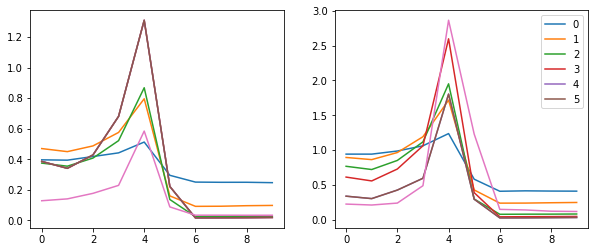

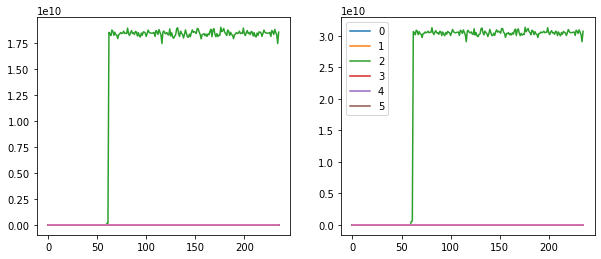

In [139]:
with Hooks(model, append_stats) as hooks:
    run.fit(2, learn)
    fig,(ax0, ax1) = plt.subplots(1,2,figsize=(10,4))
    for h in hooks:
        ms, ss=h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
    plt.legend(range(6));
    
    fig, (ax0, ax1) = plt.subplots(1,2,figsize=(10,4))
    for h in hooks:
        ms, ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(6))

# Other statistics

In [140]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'): hook.stats = ([],[],[])
    means, stds, hists = hook.stats
    means.append(outp.data.mean().cpu())
    stds .append(outp.data.std().cpu())
    hists.append(outp.data.cpu().histc(40,0,10))

In [141]:
model = get_cnn_model(data, nfs).cuda()
learn, run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [142]:
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [143]:
with Hooks(model, append_stats) as hooks:
    run.fit(1, learn)

train: [1.93048203125, tensor(0.3442, device='cuda:0')]
valid: [0.77419169921875, tensor(0.7433, device='cuda:0')]


In [144]:
def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p()

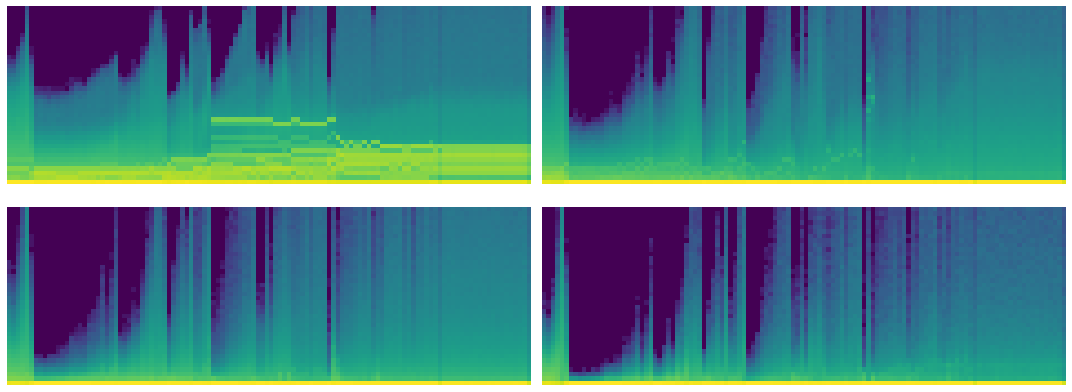

In [145]:
fig, axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

In [146]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[:2].sum(0)/h1.sum(0)

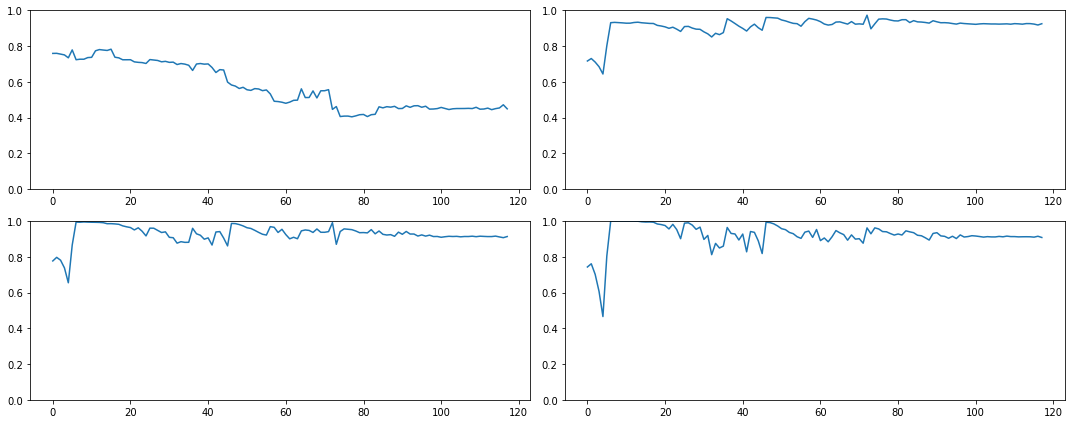

In [147]:
fig,axes = plt.subplots(2,2,figsize=(15,6))
for ax, h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()

In [148]:
def get_cnn_layers(data, nfs, layer, **kwargs):
    nfs = [1] + nfs
    return [layer(nfs[i], nfs[i+1], 5 if i==0 else 3, **kwargs)
            for i in range(len(nfs)-1)] + [
        nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def conv_layer(ni, nf, ks=3, stride=2, **kwargs):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), GeneralRelu(**kwargs))

class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak, self.sub, self.maxv = leak, sub, maxv
        
    def forward(self, x):
        x = F.leaky_relu(x, self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x.sub_(self.sub)
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x
    
def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    for l in m:
        if isinstance(l, nn.Sequential):
            f(l[0].weight, a=0.1)
            l[0].bias.data.zero_()
                
def get_cnn_model(data, nfs, layer, **kwargs):
    return nn.Sequential(*get_cnn_layers(data, nfs, layer, **kwargs))

In [149]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'): hook.stats = ([],[],[])
    means, stds, hists = hook.stats
    means.append(outp.data.mean().cpu())
    stds .append(outp.data.std().cpu())
    hists.append(outp.data.cpu().histc(40,-7,7))

In [150]:
model = get_cnn_model(data, nfs, conv_layer, leak=0.1, sub=0.4, maxv=6.)
init_cnn(model)
learn, run = get_runner(model, data, lr=0.9, cbs=cbfs)

train: [0.4875715234375, tensor(0.8488, device='cuda:0')]
valid: [0.169689892578125, tensor(0.9492, device='cuda:0')]


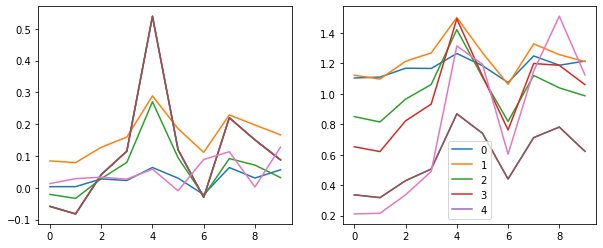

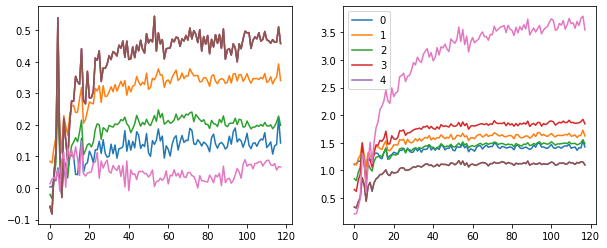

In [151]:
with Hooks(model, append_stats) as hooks:
    run.fit(1, learn)
    fig,(ax0, ax1) = plt.subplots(1,2,figsize=(10,4))
    for h in hooks:
        ms,ss,hi = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(5));
    
    fig, (ax0, ax1) = plt.subplots(1,2,figsize=(10,4))
    for h in hooks:
        ms,ss,hi = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(5))

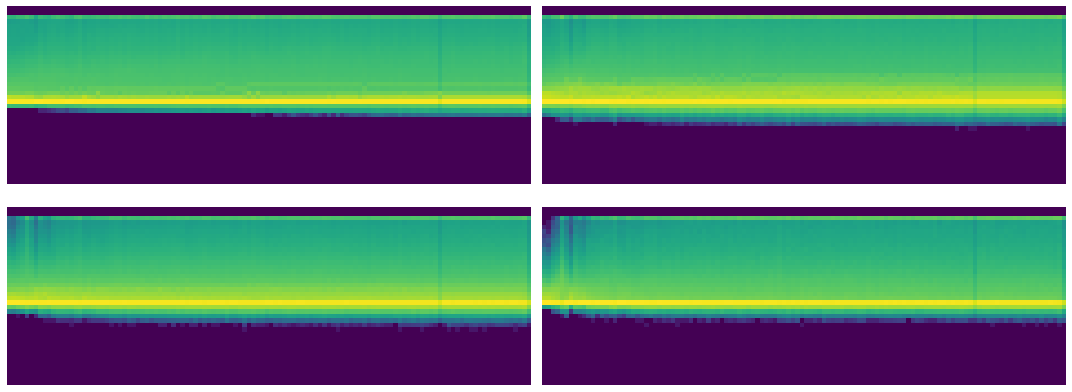

In [152]:
fig, axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

In [153]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[19,22].sum(0)/h1.sum(0)

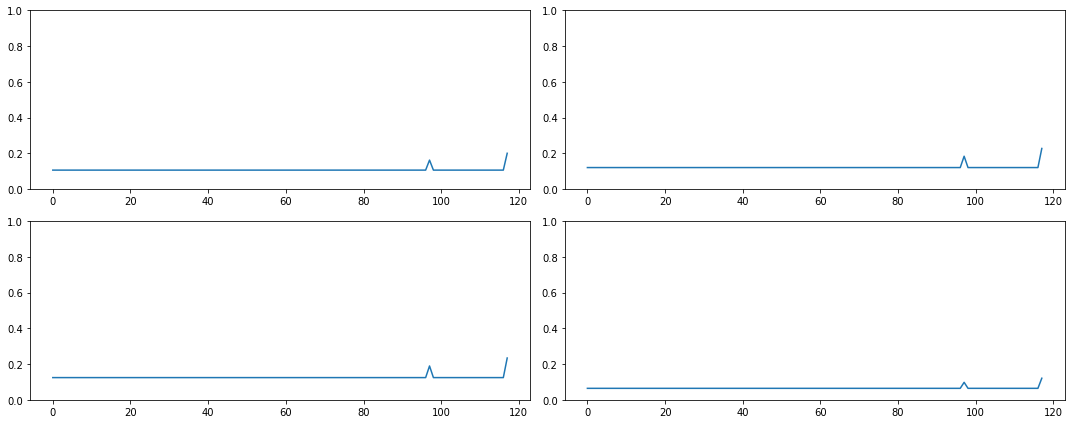

In [154]:
fig,axes = plt.subplots(2,2,figsize=(15,6))
for ax, h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()

In [155]:
def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [156]:
def sched_lin(start, end):
    def _inner(start, end, pos): return start + pos*(end-start)
    return partial(_inner, start, end)

In [157]:
def annealer(f):
    def _inner(start, end): return partial(f, start, end)
    return _inner

@annealer
def sched_lin(start, end, pos): return start + pos*(end-start)

In [158]:
@annealer
def sched_cos(start, end, pos): return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2

@annealer
def sched_no(start, end, pos): return start

@annealer
def sched_exp(start, end, pos): return start * (end/start) ** pos

torch.Tensor.ndim = property(lambda x: len(x.shape))

In [159]:
def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1
    pcts = tensor([0] + listify(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)
    def _inner(pos):
        idx = (pos >= pcts).nonzero().max()
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos)
    return _inner

In [160]:
sched = combine_scheds([0.5, 0.5], [sched_cos(0.2, 1.), sched_cos(1., 0.1)])

In [161]:
class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_func): self.pname, self.sched_func = pname, sched_func
        
    def set_param(self):
        for pg in self.opt.param_groups:
            pg[self.pname] = self.sched_func(self.n_epochs/self.epochs)
    
    def begin_batch(self):
        if self.in_train: self.set_param()

In [162]:
learn, run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs+[partial(ParamScheduler, 'lr', sched)])

In [163]:
run.fit(8, learn)

train: [1.10484609375, tensor(0.6453, device='cuda:0')]
valid: [0.312185107421875, tensor(0.9112, device='cuda:0')]
train: [0.30776521484375, tensor(0.9058, device='cuda:0')]
valid: [0.3061131103515625, tensor(0.9073, device='cuda:0')]
train: [0.223683515625, tensor(0.9313, device='cuda:0')]
valid: [0.132092333984375, tensor(0.9593, device='cuda:0')]
train: [0.144312529296875, tensor(0.9559, device='cuda:0')]
valid: [0.11766151123046875, tensor(0.9648, device='cuda:0')]
train: [0.0796473486328125, tensor(0.9758, device='cuda:0')]
valid: [0.07894000854492188, tensor(0.9760, device='cuda:0')]
train: [0.05513357421875, tensor(0.9833, device='cuda:0')]
valid: [0.0684713623046875, tensor(0.9806, device='cuda:0')]
train: [0.0412916064453125, tensor(0.9878, device='cuda:0')]
valid: [0.06360972900390625, tensor(0.9825, device='cuda:0')]
train: [0.0343570556640625, tensor(0.9902, device='cuda:0')]
valid: [0.06151495971679687, tensor(0.9834, device='cuda:0')]


In [164]:
learn, run = get_learn_run(nfs, data, 1., conv_layer, uniform=True, cbs=cbfs+[partial(ParamScheduler, 'lr', sched)])

In [165]:
run.fit(8, learn)

train: [1.1301659375, tensor(0.6443, device='cuda:0')]
valid: [0.3606755126953125, tensor(0.8836, device='cuda:0')]
train: [0.3404452734375, tensor(0.8973, device='cuda:0')]
valid: [0.2309135009765625, tensor(0.9265, device='cuda:0')]
train: [0.1975680859375, tensor(0.9388, device='cuda:0')]
valid: [0.13518519287109376, tensor(0.9570, device='cuda:0')]
train: [2.090519375, tensor(0.3538, device='cuda:0')]
valid: [2.3018134765625, tensor(0.1064, device='cuda:0')]
train: [2.301394375, tensor(0.1136, device='cuda:0')]
valid: [2.3017966796875, tensor(0.1064, device='cuda:0')]
train: [2.301306875, tensor(0.1136, device='cuda:0')]
valid: [2.3018095703125, tensor(0.1064, device='cuda:0')]
train: [2.30119296875, tensor(0.1136, device='cuda:0')]
valid: [2.3019232421875, tensor(0.1064, device='cuda:0')]
train: [2.30109796875, tensor(0.1136, device='cuda:0')]
valid: [2.301966015625, tensor(0.1064, device='cuda:0')]


# Normalization

In [166]:
mnist_view = view_tfm(1, 28, 28)
cbfs = [Recorder,
        partial(AvgStatsCallback, accuracy),
        CudaCallback,
        partial(BatchTransformXCallback, mnist_view)]

In [167]:
nfs = [8,16,32,64,64]

In [168]:
learn, run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [169]:
%time run.fit(2, learn)

train: [2.0140840625, tensor(0.3126, device='cuda:0')]
valid: [1.59062158203125, tensor(0.4294, device='cuda:0')]
train: [0.4553406640625, tensor(0.8543, device='cuda:0')]
valid: [0.20088455810546876, tensor(0.9360, device='cuda:0')]
CPU times: user 1.76 s, sys: 8.39 ms, total: 1.77 s
Wall time: 1.77 s


In [170]:
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom, self.eps = mom, eps
        self.mults = nn.Parameter(torch.ones (nf, 1, 1))
        self.adds  = nn.Parameter(torch.zeros(nf, 1,1 ))
        self.register_buffer('vars',  torch.ones(1,nf,1,1))
        self.register_buffer('means', torch.zeros(1,nf,1,1))
        
    def update_stats(self, x):
        m = x.mean((0,2,3), keepdim=True)
        v = x.var ((0,2,3), keepdim=True)
        self.means.lerp_(m, self.mom)
        self.vars.lerp_(v,  self.mom)
        return m,v
    
    def forward(self, x):
        if self.training:
            with torch.no_grad(): m,v = self.update_stats(x)
        else: m,v = self.means, self.vars
        x = (x-m) / (v + self.eps).sqrt()
        return x*self.mults + self.adds

In [171]:
bn = BatchNorm(3)

In [172]:
x = torch.rand(4,3,2,2)

In [173]:
x.mean((0,2,3), keepdim=True).shape

torch.Size([1, 3, 1, 1])

In [174]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(BatchNorm(nf))
    return nn.Sequential(*layers)

In [175]:
def init_cnn_(m, f):
    if isinstance(m, nn.Conv2d):
        f(m.weight, a=0.1)
        if getattr(m, 'bias', None) is not None: m.bias.data.zero_()
    for l in m.children(): init_cnn_(l, f)
        
def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    init_cnn_(m, f)
    
def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [176]:
learn, run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs)

train: [0.2672495703125, tensor(0.9168, device='cuda:0')]
valid: [0.569492529296875, tensor(0.8289, device='cuda:0')]


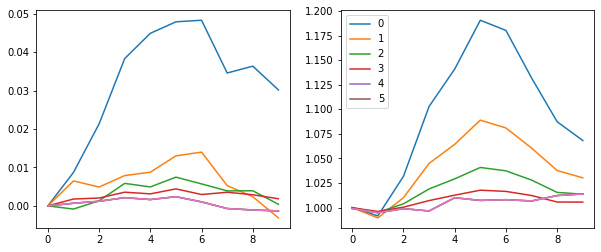

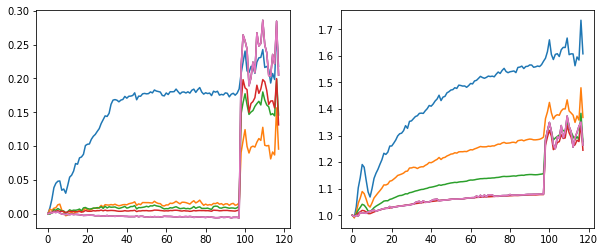

In [177]:
with Hooks(learn.model, append_stats) as hooks:
    run.fit(1, learn)
    fig,(ax0, ax1) = plt.subplots(1,2,figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss,_=h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
    plt.legend(range(6));
    
    fig, (ax0, ax1) = plt.subplots(1,2,figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss,_ = h.stats
        ax0.plot(ms)
        ax1.plot(ss)

In [178]:
learn, run = get_learn_run(nfs, data, 1.0, conv_layer, cbs=cbfs)

In [179]:
%time run.fit(3, learn)

train: [0.264976015625, tensor(0.9193, device='cuda:0')]
valid: [0.401213818359375, tensor(0.8741, device='cuda:0')]
train: [0.088348525390625, tensor(0.9731, device='cuda:0')]
valid: [0.137396142578125, tensor(0.9575, device='cuda:0')]
train: [0.0630886572265625, tensor(0.9808, device='cuda:0')]
valid: [0.10373629150390624, tensor(0.9692, device='cuda:0')]
CPU times: user 2.75 s, sys: 12 ms, total: 2.76 s
Wall time: 2.76 s


# Builtin batchnorm

In [180]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

In [181]:
learn, run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs)

In [182]:
%time run.fit(3, learn)

train: [0.2322561328125, tensor(0.9273, device='cuda:0')]
valid: [0.1072717529296875, tensor(0.9670, device='cuda:0')]
train: [0.066115947265625, tensor(0.9800, device='cuda:0')]
valid: [0.06611357421875, tensor(0.9807, device='cuda:0')]
train: [0.0429039892578125, tensor(0.9870, device='cuda:0')]
valid: [0.06149617309570313, tensor(0.9816, device='cuda:0')]
CPU times: user 2.58 s, sys: 4.17 ms, total: 2.59 s
Wall time: 2.59 s


# With scheduler

In [185]:
sched = combine_scheds([0.3, 0.7], [sched_lin(0.6, 2.), sched_lin(2., 0.1)])

In [187]:
learn, run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs +[partial(ParamScheduler, 'lr', sched)])

In [188]:
run.fit(8, learn)

train: [0.26087392578125, tensor(0.9210, device='cuda:0')]
valid: [0.122383203125, tensor(0.9622, device='cuda:0')]
train: [0.085826953125, tensor(0.9731, device='cuda:0')]
valid: [0.084973193359375, tensor(0.9732, device='cuda:0')]
train: [0.0590146728515625, tensor(0.9820, device='cuda:0')]
valid: [0.0669291259765625, tensor(0.9811, device='cuda:0')]
train: [0.03548654296875, tensor(0.9895, device='cuda:0')]
valid: [0.06074166259765625, tensor(0.9843, device='cuda:0')]
train: [0.019946876220703125, tensor(0.9946, device='cuda:0')]
valid: [0.05260296630859375, tensor(0.9845, device='cuda:0')]
train: [0.011094151611328125, tensor(0.9974, device='cuda:0')]
valid: [0.05035760803222656, tensor(0.9858, device='cuda:0')]
train: [0.0065355322265625, tensor(0.9989, device='cuda:0')]
valid: [0.04743263854980469, tensor(0.9871, device='cuda:0')]
train: [0.004489659423828125, tensor(0.9995, device='cuda:0')]
valid: [0.04482549438476562, tensor(0.9875, device='cuda:0')]


# Layer norm

In [196]:
class LayerNorm(nn.Module):
    __constants__ = ['eps']
    def __init__(self, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.mult = nn.Parameter(tensor(1.))
        self.add  = nn.Parameter(tensor(0.))
        
    def forward(self, x):
        m = x.mean((1,2,3), keepdim=True)
        v = x.std ((1,2,3), keepdim=True)
        x = (x-m) / ((v+self.eps).sqrt())
        return x*self.mult + self.add

In [197]:
def conv_ln(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True),
              GeneralRelu(**kwargs)]
    if bn: layers.append(LayerNorm())
    return nn.Sequential(*layers)

In [198]:
learn, run = get_learn_run(nfs, data, 0.8, conv_ln, cbs=cbfs)

In [199]:
%time run.fit(3, learn)

train: [nan, tensor(0.1318, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
CPU times: user 2.98 s, sys: 8.28 ms, total: 2.99 s
Wall time: 2.99 s


# Instance norm

In [200]:
class InstanceNorm(nn.Module):
    __constants__ = ['eps']
    def __init__(self, nf, eps=1e-0):
        super().__init__()
        self.eps = eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))
        
    def forward(self, x):
        m = x.mean((2,3), keepdim=True)
        v = x.std ((2,3), keepdim=True)
        res = (x-m) / ((v+self.eps).sqrt())
        return res*self.mults + self.adds

In [201]:
def conv_in(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True),
              GeneralRelu(**kwargs)]
    if bn: layers.append(InstanceNorm(nf))
    return nn.Sequential(*layers)

In [202]:
learn, run = get_learn_run(nfs, data, 0.1, conv_ln, cbs=cbfs)

In [203]:
%time run.fit(3, learn)

train: [0.5756702734375, tensor(0.8223, device='cuda:0')]
valid: [0.218757373046875, tensor(0.9333, device='cuda:0')]
train: [0.1821377734375, tensor(0.9439, device='cuda:0')]
valid: [0.14490526123046876, tensor(0.9543, device='cuda:0')]
train: [0.12750193359375, tensor(0.9606, device='cuda:0')]
valid: [0.12062122802734375, tensor(0.9635, device='cuda:0')]
CPU times: user 3.19 s, sys: 8.02 ms, total: 3.2 s
Wall time: 3.19 s


# Fix small batch sizes

In [204]:
data = DataBunch(*get_dls(train_ds, valid_ds, 2), c)

In [205]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

In [206]:
learn, run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [207]:
%time run.fit(1, learn)

train: [2.339910625, tensor(0.1811, device='cuda:0')]
valid: [63078085.4272, tensor(0.1842, device='cuda:0')]
CPU times: user 1min, sys: 434 ms, total: 1min 1s
Wall time: 1min


 # Running Batch Norm

In [220]:
class RunningBatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom, self.eps = mom, eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('sums', torch.zeros(1,nf,1,1))
        self.register_buffer('sqrs', torch.zeros(1,nf,1,1))
        self.register_buffer('batch', tensor(0.))
        self.register_buffer('count', tensor(0.))
        self.register_buffer('step',  tensor(0.))
        self.register_buffer('dbias', tensor(0.))
        
    def update_stats(self, x):
        bs,nc,*_ = x.shape
        self.sums.detach_()
        self.sqrs.detach_()
        dims = (0,2,3)
        s = x.sum(dims, keepdim=True)
        ss  = (x*x).sum(dims, keepdim=True)
        c = self.count.new_tensor(x.numel()/nc)
        self.mom1 = self.dbias.new_tensor(1 - (1-self.mom)**bs)
        self.sums.lerp_(s,  self.mom1)
        self.sqrs.lerp_(ss, self.mom1)
        self.count.lerp_(c, self.mom1)
        self.dbias.lerp_(self.mom1, self.mom1)
        self.batch += bs
        self.step += 1
        
    def forward(self, x):
        if self.training: self.update_stats(x)
        sums = self.sums
        sqrs = self.sqrs
        c = self.count
        if self.step < 100:
            sums = sums / self.dbias
            sqrs = sqrs / self.dbias
            c    = c    / self.dbias
        means = sums/c
        vars  = (sqrs/c).sub_(means*means)
        if bool(self.batch < 20): vars.clamp_min_(0.01)
        x = (x-means).div_((vars.add_(self.eps)).sqrt())
        return x.mul_(self.mults).add_(self.adds)

In [221]:
def conv_rbn(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True),
              GeneralRelu(**kwargs)]
    if bn: layers.append(RunningBatchNorm(nf))
    return nn.Sequential(*layers)

In [222]:
learn, run = get_learn_run(nfs, data, 0.4, conv_rbn, cbs=cbfs)

In [223]:
%time run.fit(1, learn)

train: [0.3586778515625, tensor(0.9091, device='cuda:0')]
valid: [0.2935740966796875, tensor(0.9551, device='cuda:0')]
CPU times: user 2min 25s, sys: 457 ms, total: 2min 25s
Wall time: 2min 25s


# What can we do in a single epoch?

In [224]:
data = DataBunch(*get_dls(train_ds, valid_ds, 32), c)

In [225]:
learn, run = get_learn_run(nfs, data, 0.9, conv_rbn, cbs=cbfs + [partial(ParamScheduler, 'lr', sched_lin(1., 0.2))])

In [226]:
%time run.fit(1, learn)

train: [0.1592632421875, tensor(0.9515, device='cuda:0')]
valid: [0.19987681884765626, tensor(0.9782, device='cuda:0')]
CPU times: user 9.12 s, sys: 41.1 ms, total: 9.16 s
Wall time: 9.15 s


# Simplified RunningBatchNorm

In [240]:
class RunningBatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom, self.eps = mom, eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('sums', torch.zeros(1,nf,1,1))
        self.register_buffer('sqrs', torch.zeros(1,nf,1,1))
        self.register_buffer('count', tensor(0.))
        self.register_buffer('factor', tensor(0.))
        self.register_buffer('offset', tensor(0.))
        self.batch = 0
        
    def update_stats(self, x):
        bs,nc,*_ = x.shape
        self.sums.detach_()
        self.sqrs.detach_()
        dims = (0,2,3)
        s    = x    .sum(dims, keepdim=True)
        ss   = (x*x).sum(dims, keepdim=True)
        c    = s.new_tensor(x.numel()/nc)
        mom1 = s.new_tensor(1 - (1-self.mom)/math.sqrt(bs-1))
        self.sums .lerp_(s,  mom1)
        self.sqrs .lerp_(ss, mom1)
        self.count.lerp_(c, mom1)
        self.batch += bs
        means = self.sums/self.count
        varns = (self.sqrs/self.count).sub_(means*means)
        if bool(self.batch < 20): varns.clamp_min_(0.01)
        self.factor = self.mults / (varns+self.eps).sqrt()
        self.offset = self.adds - means*self.factor
        
    def forward(self, x):
        if self.training: self.update_stats(x)
        return x*self.factor + self.offset

In [244]:
def conv_rbn(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True),
              GeneralRelu(**kwargs)]
    if bn: layers.append(RunningBatchNorm(nf))
    return nn.Sequential(*layers)

In [245]:
learn, run = get_learn_run(nfs, data, 0.4, conv_rbn, cbs=cbfs)

In [246]:
%time run.fit(1, learn)

train: [0.15063470703125, tensor(0.9529, device='cuda:0')]
valid: [0.09414904174804688, tensor(0.9730, device='cuda:0')]
CPU times: user 7.95 s, sys: 33.1 ms, total: 7.98 s
Wall time: 7.97 s


# Layerwise Sequential Unit Variance (LSUV)

In [249]:
x_train, y_train, x_valid, y_valid = get_data()
x_train, x_valid = normalize_to(x_train, x_valid)
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)

nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [250]:
mnist_view = view_tfm(1,28,28)
cbfs = [Recorder,
        partial(AvgStatsCallback, accuracy),
        CudaCallback,
        partial(BatchTransformXCallback, mnist_view)]

In [251]:
nfs = [8, 16, 32, 64, 64]

In [254]:
class ConvLayer(nn.Module):
    def __init__(self, ni, nf, ks=3, stride=2, sub=0., **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True)
        self.relu = GeneralRelu(sub=sub, **kwargs)
        
    def forward(self, x): return self.relu(self.conv(x))
    
    @property
    def bias(self): return -self.relu.sub
    @bias.setter
    def bias(self, v): self.relu.sub = -v
    @property
    def weight(self): return self.conv.weight

In [255]:
learn, run = get_learn_run(nfs, data, 0.6, ConvLayer, cbs=cbfs)

In [256]:
run.fit(2, learn)

train: [2.09320140625, tensor(0.2754, device='cuda:0')]
valid: [1.03661142578125, tensor(0.6227, device='cuda:0')]
train: [0.5684853125, tensor(0.8127, device='cuda:0')]
valid: [0.189953857421875, tensor(0.9435, device='cuda:0')]


In [275]:
learn,run = get_learn_run(nfs, data, 0.6, ConvLayer, cbs=cbfs)

In [276]:
def get_batch(dl, run):
    run.xb, run.yb = next(iter(dl))
    for cb in run.cbs: cb.set_runner(run)
    run('begin_batch')
    return run.xb, run.yb

In [277]:
xb, yb = get_batch(data.train_dl, run)

In [278]:
def find_modules(m, cond):
    if cond(m): return [m]
    return sum([find_modules(o, cond) for o in m.children()], [])

def is_lin_layer(l):
    lin_layers = (nn.Conv1d, nn.Conv2d, nn.Conv3d, nn.Linear, nn.ReLU)
    return isinstance(l, lin_layers)

In [279]:
mods = find_modules(learn.model, lambda o: isinstance(o, ConvLayer))

In [280]:
mods

[ConvLayer(
   (conv): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
   (relu): GeneralRelu()
 ), ConvLayer(
   (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (relu): GeneralRelu()
 ), ConvLayer(
   (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (relu): GeneralRelu()
 ), ConvLayer(
   (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (relu): GeneralRelu()
 ), ConvLayer(
   (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (relu): GeneralRelu()
 )]

In [281]:
def append_stat(hook, mod, inp, outp):
    d = outp.data
    hook.mean, hook.std = d.mean().item(), d.std().item()

In [282]:
mdl = learn.model.cuda()

In [283]:
with Hooks(mods, append_stat) as hooks:
        mdl(xb)
        for hook in hooks:print(hook.mean, hook.std)

0.38844192028045654 0.5885398983955383
0.30950042605400085 0.543411135673523
0.3004692792892456 0.498929888010025
0.23666462302207947 0.3912568986415863
0.17458514869213104 0.24389241635799408


In [284]:
def lsuv_module(m, xb):
    h = Hook(m, append_stat)
    
    while mdl(xb) is not None and abs(h.mean)  > 1e-3: m.bias -= h.mean
    while mdl(xb) is not None and abs(h.std-1) > 1e-3: m.weight.data /= h.std
        
    h.remove()
    return h.mean, h.std

In [285]:
for m in mods: print(lsuv_module(m, xb))

(0.27156758308410645, 1.0)
(0.06984634697437286, 1.0)
(0.10723279416561127, 0.9999999403953552)
(0.1606695055961609, 1.0)
(0.30224883556365967, 0.9999998807907104)


In [286]:
%time run.fit(2, learn)

train: [0.4510447265625, tensor(0.8555, device='cuda:0')]
valid: [0.13362823486328124, tensor(0.9587, device='cuda:0')]
train: [0.11391501953125, tensor(0.9643, device='cuda:0')]
valid: [0.0924847900390625, tensor(0.9709, device='cuda:0')]
CPU times: user 1.77 s, sys: 12 µs, total: 1.77 s
Wall time: 1.76 s
